<a href="https://colab.research.google.com/github/timhalter/PA-Addee/blob/main/Emotion_Vector_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install matplotlib
!pip3 install seaborn # needed for boxplots
!pip3 install NRCLex  # emotion detection

**Imports**

In [2]:
# package for natural language processing
import nltk
# List of commonly used words which we want to remove later
nltk.download("stopwords")
# Download 'punkt' tokenizer which divides a text into a list of sentences
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from nrclex import NRCLex # emotion detection
import seaborn as sns # boxplot
import re                                 
import matplotlib.pyplot as plt           
import numpy as np                    
import pandas as pd
from nltk.corpus import stopwords
from scipy.stats.mstats import winsorize  # to handle outliers in the data

**Daten herunterladen und mithilfe von Pandas zu dataframe konvertieren**

In [4]:
url = 'https://raw.githubusercontent.com/timhalter/PA-Addee/main/children_stories.Csv'
df = pd.read_csv(url,encoding='ISO-8859-1')

**Preprocessing der Buchbeschreibungen**

In [5]:
def process_text(text):    
    # Zahlen entfernen
    text = re.sub(r'\d+', ' ', text)    
    # Split bei Leerzeichen -> es entsteht eine Liste mit allen Wörtern des Textes
    text = text.split()    
    # Zusammenfügen der Wörter nach jedem Leerzeichen, Stoppwörter werden herausgefiltert
    text = ' '.join([word for word in text if word not in stopwords.words('english')])        
    return text
# Sonderzeichen entfernen
df['desc'] = df['desc'].apply(lambda x: ''.join(re.sub(r'\W', ' ', x)))
# Doppelte Leerzeichen entfernen
df['desc'] = df['desc'].apply(lambda x: ''.join(re.sub(r'\s+', ' ', x, flags=re.I)))
# In Kleinbuchstaben umwandeln
df['desc'] = df['desc'].str.lower()
df['desc'] = df['desc'].copy().apply(process_text)

In [6]:
df.head()

,names,cats,desc
0,HIDE AND SEEK,Age 2-9,another game hide seek first fell deep dark ho...
1,GINGER THE GIRAFFE,Age 2-9,read warm tale camaraderie affection set wild ...
2,DOING MY CHORES,Age 2-9,love shines great illustrated kidsâ book read ...
3,ABE THE SERVICE DOG,Age 2-9,abe real service dog dedicated life assisting ...
4,SUNNY MEADOWS WOODLAND SCHOOL,Age 2-9,class took little train went deep woods first ...


**NRCLex Beispiel: Übersicht der verschiedenen Möglichkeiten, welche NRCLex bietet**

In [7]:
text = df['desc'].iloc[0] # erste zeile einlesen
emotion = NRCLex(text)
freq = emotion.affect_frequencies
#print('\n', emotion.words)
print('\n', emotion.affect_dict)
print('\n', emotion.raw_emotion_scores)
print('\n', emotion.top_emotions)
print('\n', emotion.affect_frequencies)


 {'hide': ['fear'], 'seek': ['anticipation'], 'fell': ['negative', 'sadness'], 'dark': ['sadness'], 'ground': ['trust'], 'found': ['joy', 'positive', 'trust'], 'treasure': ['anticipation', 'joy', 'positive', 'trust'], 'thrilling': ['anticipation', 'joy', 'positive', 'surprise'], 'adventure': ['anticipation', 'positive'], 'sally': ['surprise'], 'fun': ['anticipation', 'joy', 'positive']}

 {'fear': 1, 'anticipation': 5, 'negative': 1, 'sadness': 2, 'trust': 3, 'joy': 4, 'positive': 5, 'surprise': 2}

 [('positive', 0.21739130434782608), ('anticipation', 0.21739130434782608)]

 {'fear': 0.043478260869565216, 'anger': 0.0, 'anticip': 0.0, 'trust': 0.13043478260869565, 'surprise': 0.08695652173913043, 'positive': 0.21739130434782608, 'negative': 0.043478260869565216, 'sadness': 0.08695652173913043, 'disgust': 0.0, 'joy': 0.17391304347826086, 'anticipation': 0.21739130434782608}


**Preprocessing der Altersangaben: Herausfiltern des Mindestalters**

In [8]:
# Ungültige Altersangabe entfernen
df = df.drop(df.query("cats == 'Age '").index, axis=0).reset_index(drop=True)

def min_age(sir):
    if sir.find('+')!=-1:
        if sir.find('months+')!=-1:
          return np.int(sir[:sir.find('months+')])
        else:
          return np.int(sir[:sir.find('+')])
    elif sir.find('-')!=-1:
        return np.int(sir.split('-')[0])
    elif bool(re.match(r'[0-9]+',sir)):
        return np.int(sir)
    else:
        return 'else'

# Entfernen des 'Age ' Kürzel vor jeder Altersangabe
df['cats'] = df['cats'].str.replace('Age ', '')
df['Min_Age'] = df.cats.apply(min_age)
df.drop('cats', axis=1, inplace=True)
df.head()

,names,desc,Min_Age
0,HIDE AND SEEK,another game hide seek first fell deep dark ho...,2
1,GINGER THE GIRAFFE,read warm tale camaraderie affection set wild ...,2
2,DOING MY CHORES,love shines great illustrated kidsâ book read ...,2
3,ABE THE SERVICE DOG,abe real service dog dedicated life assisting ...,2
4,SUNNY MEADOWS WOODLAND SCHOOL,class took little train went deep woods first ...,2


**Emotion Detection**

**Ablauf**
1. Listen erstellen für jede Emotion (10 total)
2. Durch jede Zeile des dataframe loopen \
Im Loop: \
2a. Emotions 'frequencies' für die Beschreibung der aktuellen Zeile holen, 
    das resultierende Objekt in '*emotion*' ist vom Typ 'Counter()' \
2b. Die Funktion getEmotionFreq() wird aufgerufen um die 10 verschiedenen Emotions-Werte in einem numpy array zu           speichern und zurückzugeben. 
3. Die einzelnen Werte des numpy Arrays '*emotions*' werden zu den ensprechenden listen hinzugefügt
4. Nach dem Loop werden für jede Emotionskategorie eine neue Spalte im Dataframe ersellt und mit den Werten                initialisiert.

In [9]:
def getEmotionFreq(emotion):
  eArr = np.zeros(11)
  for i, val in enumerate(emotion.values()):
    eArr[i] = val
  return eArr

fear = []
anger = []
trust = []
surprise = []
positive = []
negative = []
sadness = []
disgust = []
joy = []
anticipation = []

for idx, row in df.iterrows():
  text = row['desc']
  emotion = NRCLex(text).affect_frequencies
  emotions = getEmotionFreq(emotion)
  
  fear.append(emotions[0])
  anger.append(emotions[1])
  trust.append(emotions[3])
  surprise.append(emotions[4])
  positive.append(emotions[5])
  negative.append(emotions[6])
  sadness.append(emotions[7])
  disgust.append(emotions[8])
  joy.append(emotions[9])
  anticipation.append(emotions[10])

df['fear'] = fear
df['anger'] = anger
df['trust'] = trust
df['surprise'] = surprise
df['positive'] = positive
df['negative'] = negative
df['sadness'] = sadness
df['disgust'] = disgust
df['joy'] = joy
df['anticipation'] = anticipation
df.head(10)


,names,desc,Min_Age,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
0,HIDE AND SEEK,another game hide seek first fell deep dark ho...,2,0.043478,0.000000,0.130435,0.086957,0.217391,0.043478,0.086957,0.000000,0.173913,0.217391
1,GINGER THE GIRAFFE,read warm tale camaraderie affection set wild ...,2,0.125000,0.000000,0.125000,0.062500,0.312500,0.062500,0.000000,0.000000,0.187500,0.125000
2,DOING MY CHORES,love shines great illustrated kidsâ book read ...,2,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.333333
3,ABE THE SERVICE DOG,abe real service dog dedicated life assisting ...,2,0.000000,0.000000,0.250000,0.050000,0.400000,0.000000,0.000000,0.000000,0.150000,0.150000
4,SUNNY MEADOWS WOODLAND SCHOOL,class took little train went deep woods first ...,2,0.090909,0.000000,0.181818,0.181818,0.181818,0.090909,0.000000,0.000000,0.090909,0.181818
5,TOOTH FAIRY,wonderful story weaves magic childâ imaginatio...,2,0.000000,0.000000,0.181818,0.090909,0.272727,0.000000,0.000000,0.000000,0.181818,0.272727
6,HAMMY THE HAMSTER,heâ got swag wears tux heâ hipster hamster lik...,2,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,THE CASE OF THE MISSING SMILE,detective peterson trying find sally sue lost ...,2,0.000000,0.055556,0.111111,0.166667,0.222222,0.166667,0.111111,0.000000,0.166667,0.000000
8,HOMEWORK - YUCK!,jamal made case next open house mattered much ...,2,0.066667,0.000000,0.266667,0.066667,0.333333,0.066667,0.066667,0.000000,0.066667,0.066667
9,CAPTAIN FANTASTIC,dr zobâ evil plans failed thanks wonder dog wi...,2,0.055556,0.055556,0.111111,0.111111,0.277778,0.055556,0.055556,0.055556,0.166667,0.055556


**Winsorisieren**

In dieser Methode werden Ausreisser nach unten & oben korrigiert.
Dazu wird die Statistik-Funktion '*winsorize*' von scipy verwendet.
Die Emotions-Daten werden winsorisiert, das heisst Ausreisser
werden mithilfe von Extremwerten begrenzt. 
In diesem Fall wird eine Winsorisierung von 70% angewendet. 
Daten unterhalb des 15. Perzentils werden auf das 15. Perzentil gesetzt. Daten oberhalb des 85. Perzentils werden auf das 85. Perzentil gesetzt.

In [10]:
def reduce_outliers(df_age):
  for idx, column in enumerate(df_age.columns):
        if idx > 2:
          df_temp = df_age.iloc[:, idx].copy()
          df_age.iloc[:, idx] = winsorize(df_temp, (0.15, 0.15))
  return df_age

In [11]:
# Methode für Boxplots
def show_boxplot(desc, df_age):
  plt.title(desc)
  ax = sns.boxplot(data=df_age.iloc[:,3:])
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
  plt.show()

In [12]:
# Erstelle Kopie des dataframes
df_copy = df.copy()

In diesem Schritt werden die Daten nach Mindestalter gefiltert und in einem separaten *dataframe* gespeichert. Dies ist nötig um die Ausreisser korrigieren zu können.

In [13]:
df_age0 = df_copy[df_copy['Min_Age']==0]
df_age1 = df_copy[df_copy['Min_Age']==1]
df_age2 = df_copy[df_copy['Min_Age']==2]
df_age3 = df_copy[df_copy['Min_Age']==3]
df_age4 = df_copy[df_copy['Min_Age']==4]
df_age5 = df_copy[df_copy['Min_Age']==5]
df_age6 = df_copy[df_copy['Min_Age']==6]
df_age7 = df_copy[df_copy['Min_Age']==7]
df_age8 = df_copy[df_copy['Min_Age']==8]
df_age9 = df_copy[df_copy['Min_Age']==9]
df_age10 = df_copy[df_copy['Min_Age']==10]
df_age11 = df_copy[df_copy['Min_Age']==11]
df_age12 = df_copy[df_copy['Min_Age']==12]
df_age13 = df_copy[df_copy['Min_Age']==13]


In [14]:
df_age0.iloc[:,3:].head()

,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
22,0.136364,0.090909,0.204545,0.045455,0.204545,0.045455,0.022727,0.022727,0.136364,0.090909
24,0.027778,0.055556,0.138889,0.069444,0.291667,0.083333,0.013889,0.013889,0.166667,0.138889
25,0.021739,0.043478,0.173913,0.108696,0.282609,0.043478,0.043478,0.043478,0.152174,0.086957
26,0.127660,0.063830,0.127660,0.042553,0.212766,0.042553,0.042553,0.021277,0.106383,0.212766
29,0.000000,0.000000,0.176471,0.000000,0.352941,0.000000,0.000000,0.000000,0.294118,0.176471


**Boxplots aller Alterskategorien und deren gemessenen Emotionen** \


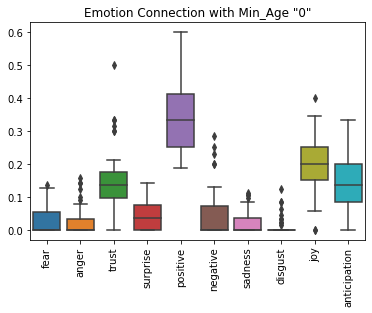

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


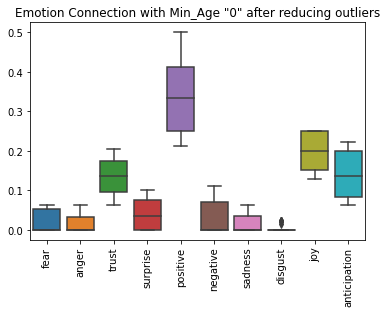

In [15]:
show_boxplot('Emotion Connection with Min_Age "0"', df_age0)

df_age0 = reduce_outliers(df_age0)

show_boxplot('Emotion Connection with Min_Age "0" after reducing outliers', df_age0)

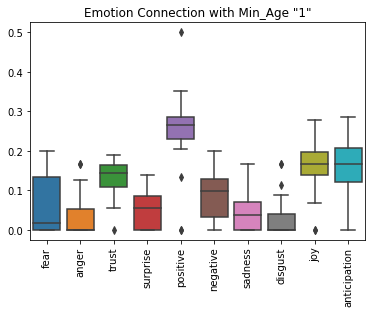

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


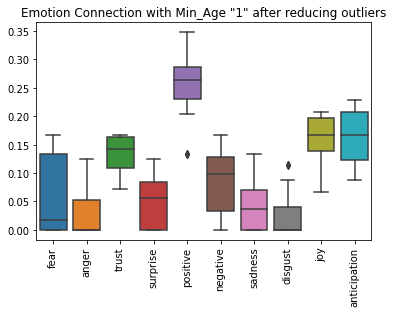

In [16]:
show_boxplot('Emotion Connection with Min_Age "1"', df_age1)

df_age1 = reduce_outliers(df_age1)

show_boxplot('Emotion Connection with Min_Age "1" after reducing outliers', df_age1)

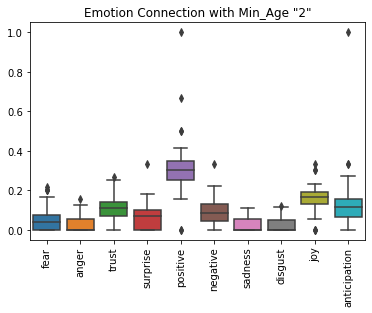

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


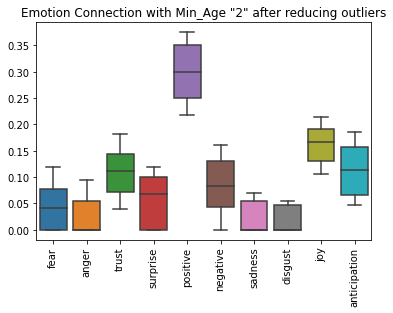

In [17]:
show_boxplot('Emotion Connection with Min_Age "2"', df_age2)

df_age2 = reduce_outliers(df_age2)

show_boxplot('Emotion Connection with Min_Age "2" after reducing outliers', df_age2)

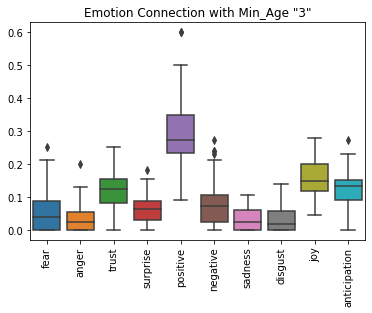

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


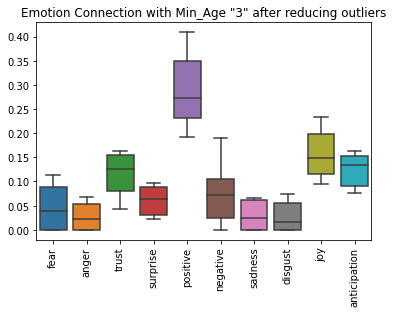

In [18]:
show_boxplot('Emotion Connection with Min_Age "3"', df_age3)

df_age3 = reduce_outliers(df_age3)

show_boxplot('Emotion Connection with Min_Age "3" after reducing outliers', df_age3)

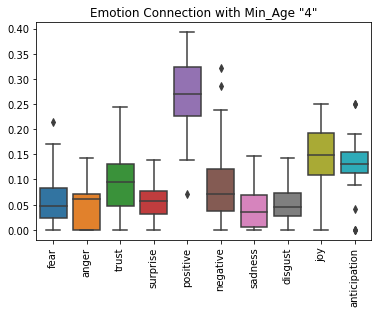

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


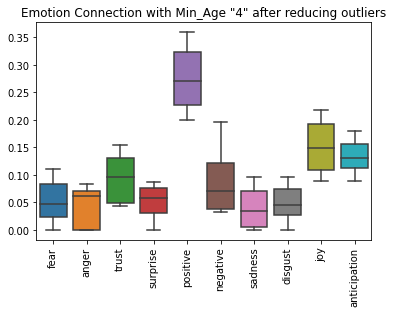

In [19]:
show_boxplot('Emotion Connection with Min_Age "4"', df_age4)

df_age4 = reduce_outliers(df_age4)

show_boxplot('Emotion Connection with Min_Age "4" after reducing outliers', df_age4)

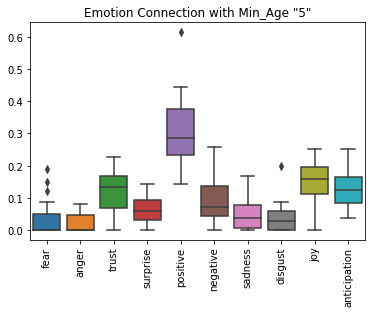

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


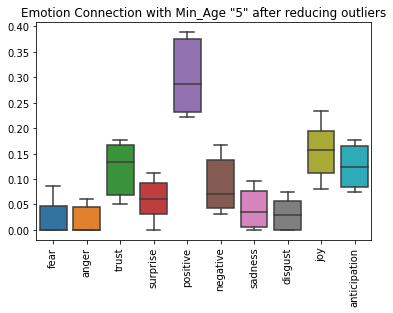

In [20]:
show_boxplot('Emotion Connection with Min_Age "5"', df_age5)

df_age5 = reduce_outliers(df_age5)

show_boxplot('Emotion Connection with Min_Age "5" after reducing outliers', df_age5)

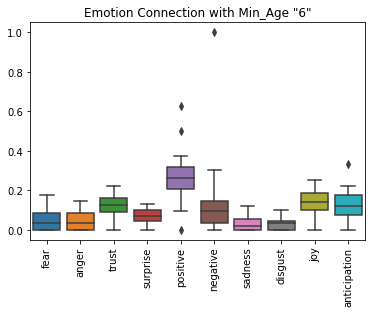

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


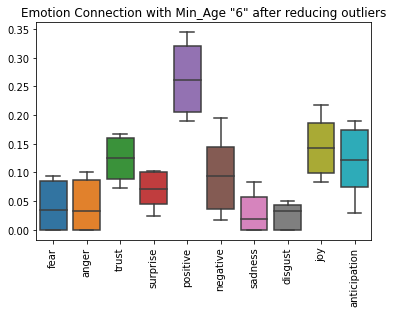

In [21]:
show_boxplot('Emotion Connection with Min_Age "6"', df_age6)

df_age6 = reduce_outliers(df_age6)

show_boxplot('Emotion Connection with Min_Age "6" after reducing outliers', df_age6)

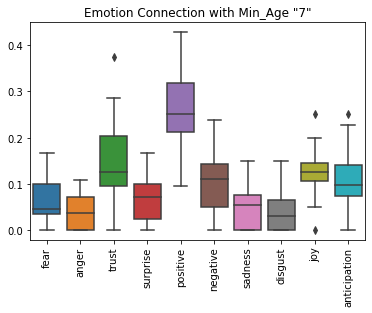

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


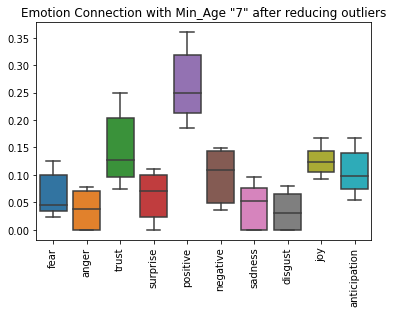

In [22]:
show_boxplot('Emotion Connection with Min_Age "7"', df_age7)

df_age7 = reduce_outliers(df_age7)

show_boxplot('Emotion Connection with Min_Age "7" after reducing outliers', df_age7)

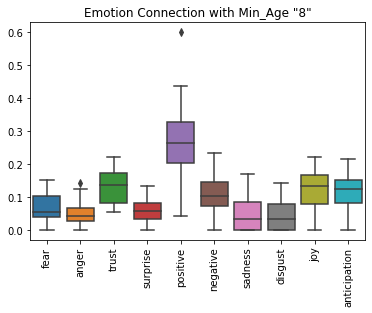

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


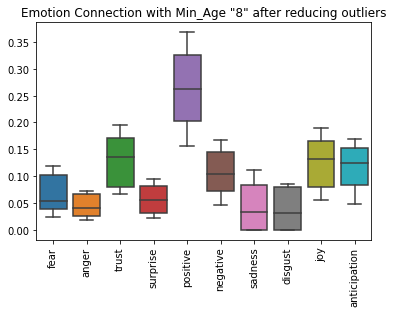

In [23]:
show_boxplot('Emotion Connection with Min_Age "8"', df_age8)

df_age8 = reduce_outliers(df_age8)

show_boxplot('Emotion Connection with Min_Age "8" after reducing outliers', df_age8)

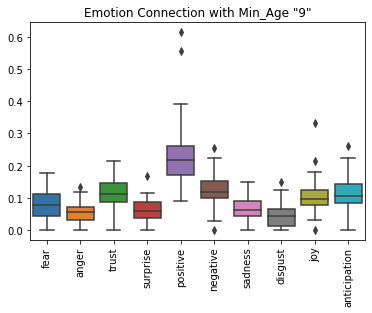

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


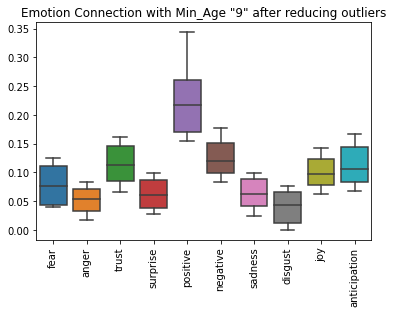

In [24]:
show_boxplot('Emotion Connection with Min_Age "9"', df_age9)

df_age9 = reduce_outliers(df_age9)

show_boxplot('Emotion Connection with Min_Age "9" after reducing outliers', df_age9)

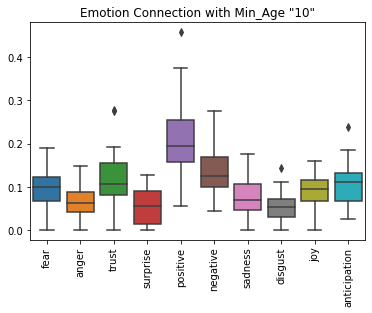

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


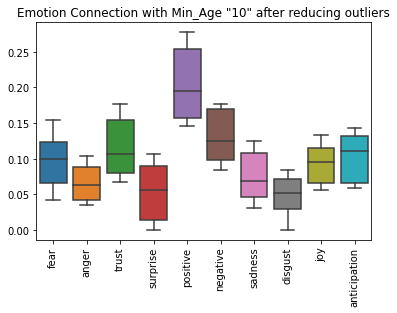

In [25]:
show_boxplot('Emotion Connection with Min_Age "10"', df_age10)

df_age10 = reduce_outliers(df_age10)

show_boxplot('Emotion Connection with Min_Age "10" after reducing outliers', df_age10)

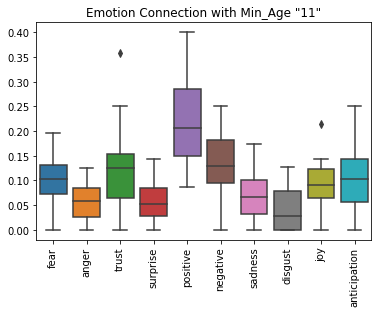

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


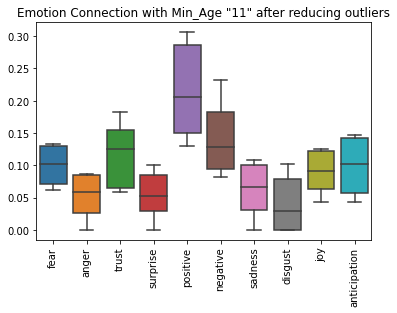

In [26]:
show_boxplot('Emotion Connection with Min_Age "11"', df_age11)

df_age11 = reduce_outliers(df_age11)

show_boxplot('Emotion Connection with Min_Age "11" after reducing outliers', df_age11)

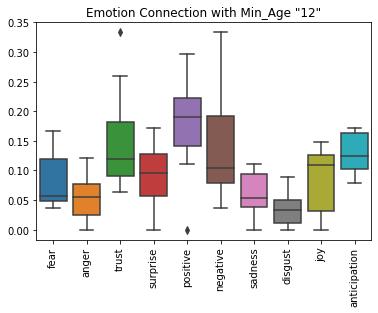

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


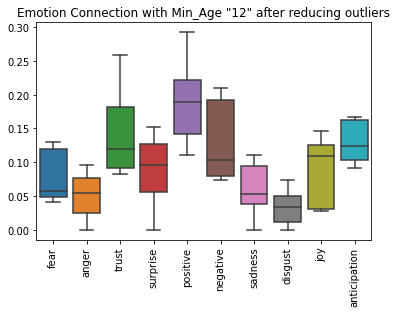

In [27]:
show_boxplot('Emotion Connection with Min_Age "12"', df_age12)

df_age12 = reduce_outliers(df_age12)

show_boxplot('Emotion Connection with Min_Age "12" after reducing outliers', df_age12)

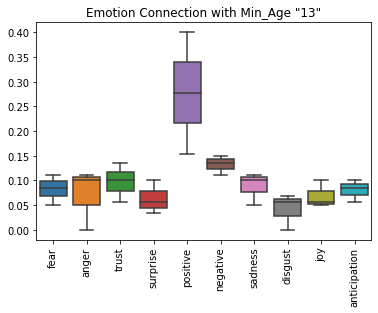

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


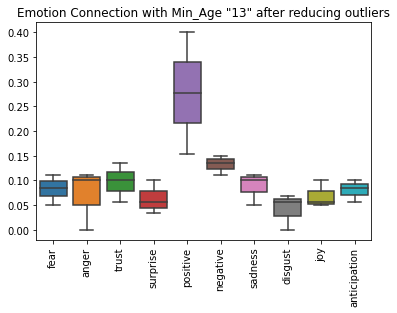

In [28]:
show_boxplot('Emotion Connection with Min_Age "13"', df_age13)

df_age13 = reduce_outliers(df_age13)

show_boxplot('Emotion Connection with Min_Age "13" after reducing outliers', df_age13)

Die separierten *dataframes*, bei denen die Ausreisser korrigiert wurden, werden nun wieder in die Kopie des ursprünglichen dataframes geschrieben.

In [29]:
df_copy[df_copy['Min_Age'] == 0] = df_age0
df_copy[df_copy['Min_Age'] == 1] = df_age1
df_copy[df_copy['Min_Age'] == 2] = df_age2
df_copy[df_copy['Min_Age'] == 3] = df_age3
df_copy[df_copy['Min_Age'] == 4] = df_age4
df_copy[df_copy['Min_Age'] == 5] = df_age5
df_copy[df_copy['Min_Age'] == 6] = df_age6
df_copy[df_copy['Min_Age'] == 7] = df_age7
df_copy[df_copy['Min_Age'] == 8] = df_age8
df_copy[df_copy['Min_Age'] == 9] = df_age9
df_copy[df_copy['Min_Age'] == 10] = df_age10
df_copy[df_copy['Min_Age'] == 11] = df_age11
df_copy[df_copy['Min_Age'] == 12] = df_age12
df_copy[df_copy['Min_Age'] == 13] = df_age13

df_copy.head()

,names,desc,Min_Age,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
0,HIDE AND SEEK,another game hide seek first fell deep dark ho...,2,0.043478,0.0,0.130435,0.086957,0.217391,0.043478,0.068966,0.0,0.173913,0.185185
1,GINGER THE GIRAFFE,read warm tale camaraderie affection set wild ...,2,0.119048,0.0,0.125000,0.062500,0.312500,0.062500,0.000000,0.0,0.187500,0.125000
2,DOING MY CHORES,love shines great illustrated kidsâ book read ...,2,0.000000,0.0,0.040000,0.000000,0.333333,0.000000,0.000000,0.0,0.214286,0.185185
3,ABE THE SERVICE DOG,abe real service dog dedicated life assisting ...,2,0.000000,0.0,0.181818,0.050000,0.375000,0.000000,0.000000,0.0,0.150000,0.150000
4,SUNNY MEADOWS WOODLAND SCHOOL,class took little train went deep woods first ...,2,0.090909,0.0,0.181818,0.120000,0.217391,0.090909,0.000000,0.0,0.105263,0.181818


In [30]:
df.head()

,names,desc,Min_Age,fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation
0,HIDE AND SEEK,another game hide seek first fell deep dark ho...,2,0.043478,0.0,0.130435,0.086957,0.217391,0.043478,0.086957,0.0,0.173913,0.217391
1,GINGER THE GIRAFFE,read warm tale camaraderie affection set wild ...,2,0.125000,0.0,0.125000,0.062500,0.312500,0.062500,0.000000,0.0,0.187500,0.125000
2,DOING MY CHORES,love shines great illustrated kidsâ book read ...,2,0.000000,0.0,0.000000,0.000000,0.333333,0.000000,0.000000,0.0,0.333333,0.333333
3,ABE THE SERVICE DOG,abe real service dog dedicated life assisting ...,2,0.000000,0.0,0.250000,0.050000,0.400000,0.000000,0.000000,0.0,0.150000,0.150000
4,SUNNY MEADOWS WOODLAND SCHOOL,class took little train went deep woods first ...,2,0.090909,0.0,0.181818,0.181818,0.181818,0.090909,0.000000,0.0,0.090909,0.181818


Es ist ersichtlich, dass die Reihenfolge der Daten auch nach dem Separieren und Winsorisieren und Zusammenfügen noch mit dem Original übereinstimmt.

**Boxplots aller Emotionen in Verbindung zu den Altersklassen** \
Nachfolgend werden einige Boxplots erstellt, welche die Verbidung einzelner Emotionen zu den Altersklassen zeigen.

In [31]:
def show_boxplot_xy(desc, df_x, df_y):
  plt.title(desc)
  ax = sns.boxplot(y=df_y,x=df_x)
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
  plt.show()

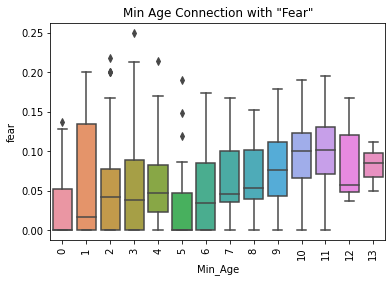

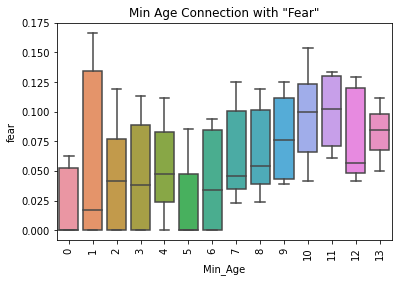

In [32]:
show_boxplot_xy('Min Age Connection with "Fear"', df['Min_Age'], df['fear'])
show_boxplot_xy('Min Age Connection with "Fear"', df_copy['Min_Age'], df_copy['fear'])

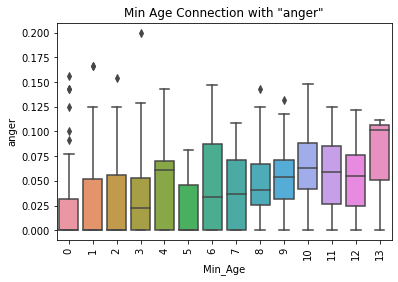

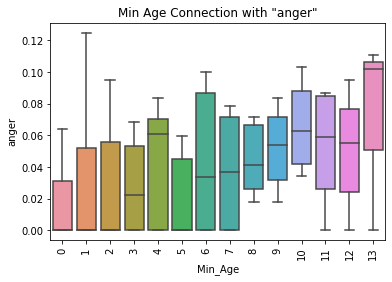

In [33]:
show_boxplot_xy('Min Age Connection with "anger"', df['Min_Age'], df['anger'])
show_boxplot_xy('Min Age Connection with "anger"', df_copy['Min_Age'], df_copy['anger'])

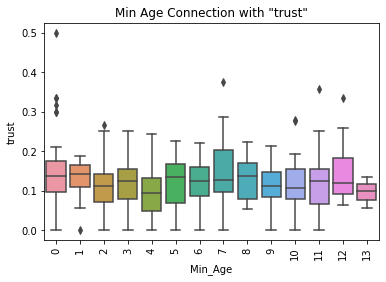

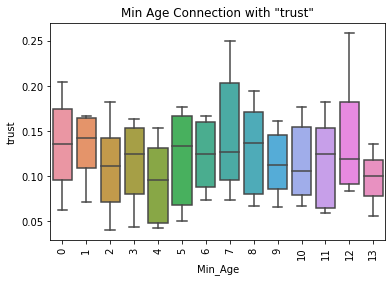

In [34]:
show_boxplot_xy('Min Age Connection with "trust"', df['Min_Age'], df['trust'])
show_boxplot_xy('Min Age Connection with "trust"', df_copy['Min_Age'], df_copy['trust'])

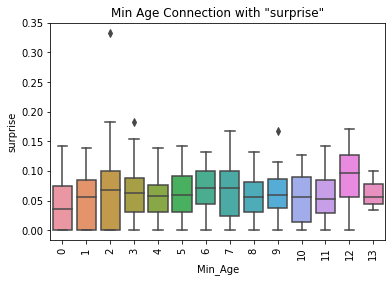

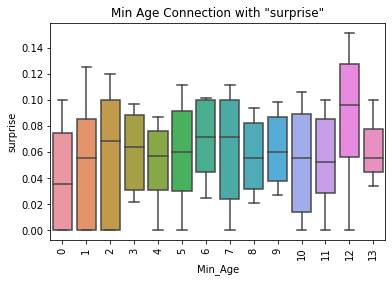

In [35]:
show_boxplot_xy('Min Age Connection with "surprise"', df['Min_Age'], df['surprise'])
show_boxplot_xy('Min Age Connection with "surprise"', df_copy['Min_Age'], df_copy['surprise'])

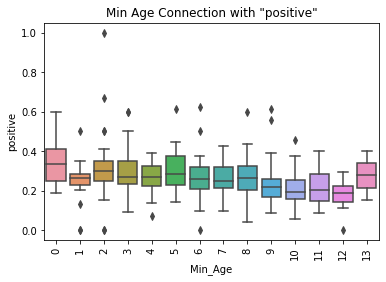

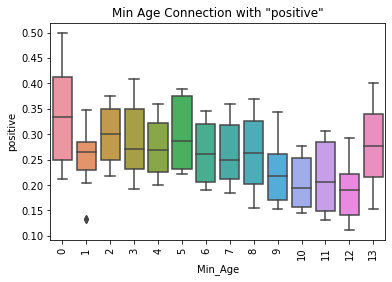

In [36]:
show_boxplot_xy('Min Age Connection with "positive"', df['Min_Age'], df['positive'])
show_boxplot_xy('Min Age Connection with "positive"', df_copy['Min_Age'], df_copy['positive'])

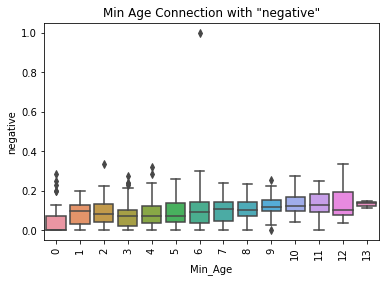

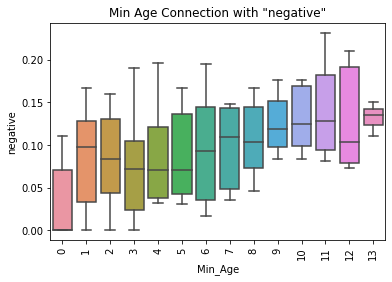

In [37]:
show_boxplot_xy('Min Age Connection with "negative"', df['Min_Age'], df['negative'])
show_boxplot_xy('Min Age Connection with "negative"', df_copy['Min_Age'], df_copy['negative'])

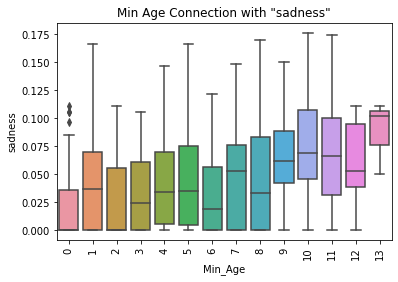

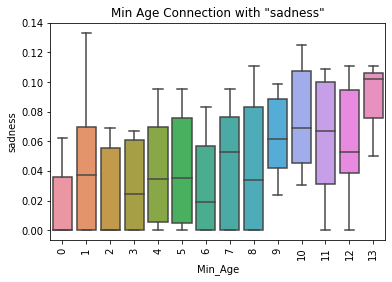

In [38]:
show_boxplot_xy('Min Age Connection with "sadness"', df['Min_Age'], df['sadness'])
show_boxplot_xy('Min Age Connection with "sadness"', df_copy['Min_Age'], df_copy['sadness'])

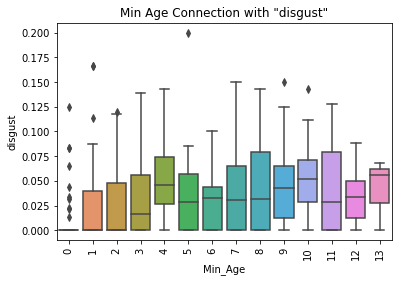

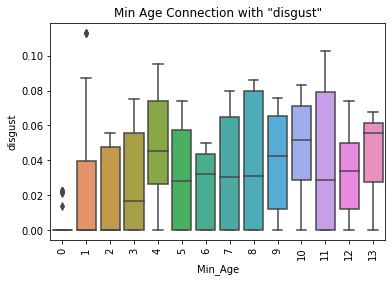

In [39]:
show_boxplot_xy('Min Age Connection with "disgust"', df['Min_Age'], df['disgust'])
show_boxplot_xy('Min Age Connection with "disgust"', df_copy['Min_Age'], df_copy['disgust'])

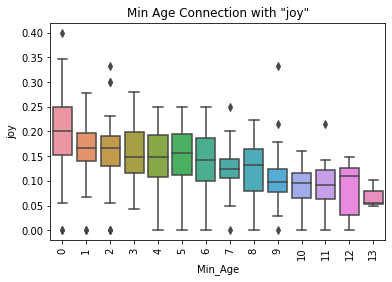

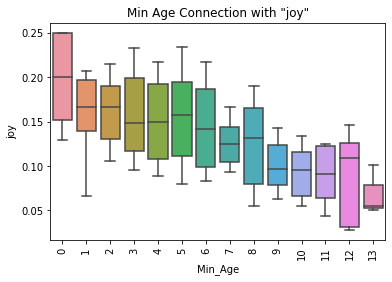

In [40]:
show_boxplot_xy('Min Age Connection with "joy"', df['Min_Age'], df['joy'])
show_boxplot_xy('Min Age Connection with "joy"', df_copy['Min_Age'], df_copy['joy'])

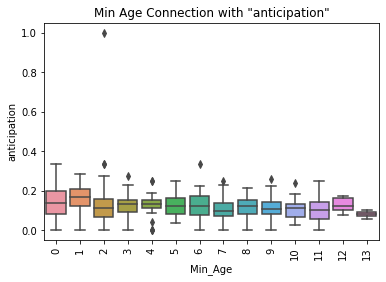

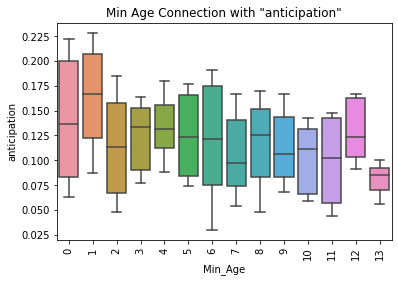

In [41]:
show_boxplot_xy('Min Age Connection with "anticipation"', df['Min_Age'], df['anticipation'])
show_boxplot_xy('Min Age Connection with "anticipation"', df_copy['Min_Age'], df_copy['anticipation'])

Anhand der obigen Plots sind einige Korrelationen zu erkennen. Vorallem bei den Emotionen 'Fear', 'Sadness' und 'Joy' kann man klare Unterschiede bei den verschiedenen Altersklassen erkennen.
Anhand dieser Erkenntnisse sollen die verschiedenen Alterskategorien abgeleitet werden, welche jeweils mehrere Altersklassen umfangen.